<a href="https://colab.research.google.com/github/mancunian1792/causal_scene_generation/blob/master/causal_model/game_characters/vae_svi/causal_VAE_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pip install pyro-ppl==1.3.1
!pip install visdom
import torch.nn as nn
import pyro
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader ,random_split
from torchvision import datasets ,models , transforms
from torch import nn
import torch.nn.functional as F
from functools import reduce
import matplotlib.pyplot as plt
import pyro.distributions as dist

Mounted at /content/gdrive
     |████████████████████████████████| 522kB 2.9MB/s 
     |████████████████████████████████| 686kB 3.0MB/s 
     |████████████████████████████████| 204kB 9.2MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655251 sha256=43166c835e0efb38b5667d3246c18775662c493afa16a45cc54db68dcfd35250
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=3710d66e0e9e2234d8177ba8d3f8d9734763743aa0053f7ac9f260a2f53a600c
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


### DataLoader

In [ ]:


def split_tensor(idx, sample, length):
    if idx==0:
        return sample[..., 0:length]
    return sample[..., length:]

values = {
      "action": ["Attacking", "Taunt", "Walking"],
      "reaction": ["Dying", "Hurt", "Idle", "Attacking"],
      "strength": ["Low", "High"],
      "defense": ["Low", "High"],
      "attack": ["Low", "High"],
      "actor": ["Satyr", "Golem"],
      "reactor": ["Satyr", "Golem"],
      "Satyr": ["satyr1", "satyr2", "satyr3"],
      "Golem": ["golem1", "golem2", "golem3"]
  }


class GameCharacterFullData(Dataset):
  def __init__(self, transforms, root_path, mode):
    # Change the following path to a more generalizable form. Like download it from
    # github or something like that. Make it usable to anyone.
    self.root_path = root_path
    self.train_path = self.root_path + 'train/'
    self.test_path = self.root_path + 'test/'
    self.train_csv = self.train_path + 'train.csv'
    self.test_csv = self.test_path + 'test.csv'
    self.mode = mode
    self.train_df = pd.read_csv(self.train_csv)
    self.test_df = pd.read_csv(self.test_csv)
    self.transforms = transforms

  def __getitem__(self, idx):
    if self.mode == "train":
      d = self.train_df.iloc[idx]
      image = Image.open(self.train_path + d["img_name"] + ".png").convert("RGB")
    else:
      d = self.test_df.iloc[idx]
      image = Image.open(self.test_path + d["img_name"] + ".png").convert("RGB")
        
    # Extracting only the action reaction labels, coz that's what we condition on.
    actor = torch.tensor(d[["actor_name_Satyr", "actor_name_Golem"]].tolist(), dtype=torch.float32)

    reactor = torch.tensor(d[["reactor_name_Satyr", "reactor_name_Golem"]].tolist(), dtype=torch.float32)
    
    actor_type = torch.tensor(d[["actor_type_type1", "actor_type_type2", "actor_type_type3"]].tolist(), dtype=torch.float32)
    #actor_type = split_tensor(actor_idx, actor_type, len(values[(values["actor"][actor_idx])]))

    reactor_type = torch.tensor(d[["reactor_type_type1", "reactor_type_type2", "reactor_type_type3"]].tolist(), dtype=torch.float32)
    #reactor_type = split_tensor(reactor_idx, reactor_type, len(values[(values["actor"][reactor_idx])]))


    action = torch.tensor(d[["actor_action_Attacking", "actor_action_Taunt", "actor_action_Walking"]].tolist(), dtype=torch.float32)
    reaction = torch.tensor(d[["reactor_action_Dying", "reactor_action_Hurt", "reactor_action_Idle", "reactor_action_Attacking", ]].tolist(), dtype=torch.float32)

    cols_order = ["actor_name_Satyr", "actor_name_Golem", "actor_type_type1",
             "actor_type_type2", "actor_type_type3", "actor_action_Attacking", "actor_action_Taunt", "actor_action_Walking",
             "reactor_name_Satyr", "reactor_name_Golem", "reactor_type_type1", "reactor_type_type2",
             "reactor_type_type3","reactor_action_Dying", "reactor_action_Hurt", "reactor_action_Idle", "reactor_action_Attacking"]
    
    label = torch.tensor(d[cols_order].tolist(), dtype=torch.float32)
    if self.transforms is not None:
        
        xp = self.transforms(image)
      # transform x to a linear tensor from bx * a1 * a2 * ... --> bs * A
        #xp_1d_size = reduce(lambda a, b: a * b, xp.size()[1:])

        #xp = xp.view(-1, xp_1d_size)
        #xp = xp.squeeze(0)
        assert not np.isnan(xp.sum())
    return xp, label, actor, reactor, actor_type, reactor_type, action, reaction

  def __len__(self):
    if self.mode == "train":
      return self.train_df.shape[0]
    else:
      return self.test_df.shape[0]

def setup_data_loaders(dataset, root_path, batch_size, transforms):
    train_dataset = dataset(transforms["train"], root_path, mode="train")
    test_dataset = dataset(transforms["test"], root_path, mode="test")    

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

    return train_loader, test_loader

### Causal VAE Model

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

values = {
      "action": ["Attacking", "Taunt", "Walking"],
      "reaction": ["Dying", "Hurt", "Idle", "Attacking"],
      "strength": ["Low", "High"],
      "defense": ["Low", "High"],
      "attack": ["Low", "High"],
      "actor": ["Satyr", "Golem"],
      "reactor": ["Satyr", "Golem"],
      "Satyr": ["satyr1", "satyr2", "satyr3"],
      "Golem": ["golem1", "golem2", "golem3"]
  }

cpts = {
    "action": torch.tensor([[[[0.1, 0.3, 0.6], [0.3, 0.5, 0.2]], [[0.3, 0.4, 0.4], [0.5,0.4,0.1]]],
                              [[[0.1, 0.2, 0.7], [0.4,0.3,0.3]], [[0.2, 0.4, 0.4], [0.6, 0.3, 0.1]]]]),
    
    "reaction": torch.tensor([[[[[0.5, 0.4, 0.05, 0.05], [0.2, 0.6, 0.1, 0.1], [0.001, 0.001, 0.997, 0.001]],
                    [[0.4, 0.3,0.1, 0.2], [0.1, 0.5, 0.2, 0.2], [0.001, 0.001, 0.99, 0.008]]],
                    [[[0.1, 0.3, 0.55, 0.05], [0.1, 0.2, 0.65, 0.05], [0.001, 0.001, 0.997, 0.001]],
                    [[0.3, 0.2, 0.3, 0.2],[0.1, 0.3, 0.4, 0.2],[0.001, 0.001, 0.99, 0.008]]]],
                  [[[[0.3, 0.3, 0.399, 0.001],[0.2, 0.4, 0.399, 0.001],[0.001, 0.001, 0.997, 0.001]],
                    [[0.3, 0.4, 0.1, 0.2],[0.3, 0.3, 0.1, 0.3],[0.001, 0.001, 0.99, 0.008]]],
                    [[[0.2, 0.3, 0.49, 0.01],[0.1, 0.2, 0.69, 0.01],[0.001, 0.001, 0.997, 0.001]],
                    [[0.2, 0.2, 0.4, 0.2],[0.1, 0.1, 0.4, 0.4],[0.001, 0.001, 0.99, 0.008]]]]]),
    "character": torch.tensor([0.5, 0.5]),
    "type": torch.tensor([[0.33, 0.34, 0.33], [0.33, 0.34, 0.33]]),
    "strength": torch.tensor([[[0.4, 0.6], [0.2, 0.8], [0.5, 0.5]], [[0.6, 0.4], [0.5, 0.5], [0.8, 0.2]]]),
    "defense": torch.tensor([[[0.9, 0.1], [0.3, 0.7], [0.6, 0.4]], [[0.5, 0.5], [0.4, 0.6], [0.6, 0.4]]]),
    "attack": torch.tensor([[[0.2, 0.8], [0.6, 0.4], [0.8, 0.2]], [[0.75, 0.25], [0.4, 0.6], [0.9, 0.1]]])
}

## The inverse cpts were obtained from R grain object and hence those probabilities were copied and constructed into tensors.

def convert_prob_string_to_tensor(prob_string, reshape_dim):
    prob_list = [float(x) for x in prob_string.split(" ")]
    return torch.FloatTensor(prob_list).reshape(*reshape_dim).cuda()

inverse_cpts = {
    "reaction_strength": convert_prob_string_to_tensor("0.6125566 0.3874434 0.6133058 0.3866942 0.6192763 0.3807237 0.6179714 0.3820286 0.6149248 0.3850752 0.6121950 0.3878050 0.5191074 \
0.4808926 0.5401218 0.4598782 0.5273679 0.4726321 0.5169132 0.4830868 0.5500905 0.4499095 0.5527345 0.4472655 0.4584787 0.5415213 \
0.4553537 0.5446463 0.4549462 0.5450538 0.4568998 0.5431002 0.4535802 0.5464198 0.4542053 0.5457947 0.5010396 0.4989604 0.4848076 \
0.5151924 0.4935912 0.5064088 0.5027230 0.4972770 0.4783055 0.5216945 0.4771059 0.5228941", [4,3,2,2]),
    "reaction_defense": convert_prob_string_to_tensor("0.6661711 0.3338289 0.6525923 0.3474077 0.6628215 0.3371785 0.6695031 0.3304969 0.6468932 0.3531068 0.6444372 0.3555628 0.6253805 \
0.3746195 0.6080135 0.3919865 0.6230644 0.3769356 0.6309901 0.3690099 0.6007180 0.3992820 0.5964528 0.4035472 0.4898905 0.5101095 \
0.5024586 0.4975414 0.4913484 0.5086516 0.4851282 0.5148718 0.5071608 0.4928392 0.5099597 0.4900403 0.5215942 0.4784058 0.5262604 \
0.4737396 0.5265067 0.4734933 0.5236084 0.4763916 0.5286241 0.4713759 0.5278925 0.4721075", [4,3,2,2]),
    "reaction_attack": convert_prob_string_to_tensor("0.5947227 0.4052773 0.6044461 0.3955539 0.6010424 0.3989576 0.5956961 0.4043039 0.6093099 0.3906901 0.6093492 0.3906508 0.6007418 \
0.3992582 0.6116749 0.3883251 0.6064754 0.3935246 0.6008088 0.3991912 0.6171615 0.3828385 0.6178749 0.3821251 0.6056244 0.3943756 \
0.5926854 0.4073146 0.5996507 0.4003493 0.6066288 0.3933712 0.5869918 0.4130082 0.5859743 0.4140257 0.6515096 0.3484904 0.6822071 \
0.3177929 0.6619430 0.3380570 0.6450330 0.3549670 0.6938520 0.3061480 0.6975395 0.3024605", [4,3,2,2]),
    "action_strength": convert_prob_string_to_tensor("0.3427173 0.6572827 0.6122449 0.3877551 0.2010050 0.7989950 0.4748603 0.5251397 0.5140187 0.4859813 0.8213552 0.1786448 0.5148064 \
0.4851936 0.6279070 0.3720930 0.2135922 0.7864078 0.5549133 0.4450867 0.5389610 0.4610390 0.8175938 0.1824062 0.3329193 0.6670807 \
0.5722543 0.4277457 0.1863636 0.8136364 0.4662162 0.5337838 0.4686192 0.5313808 0.7806452 0.2193548", [3,3,2,2]),
    "action_defense": convert_prob_string_to_tensor("0.84822521 0.15177479 0.32653061 0.67346939 0.19974874 0.80025126 0.27932961 0.72067039 0.42056075 0.57943925 0.37577002 0.62422998 \
0.90205011 0.09794989 0.46511628 0.53488372 0.24393204 0.75606796 0.39306358 0.60693642 0.54545455 0.45454545 0.57826649 0.42173351 \
0.95031056 0.04968944 0.62427746 0.37572254 0.44318182 0.55681818 0.55405405 0.44594595 0.71548117 0.28451883 0.70161290 0.29838710", [3,3,2,2]),
    "action_attack": convert_prob_string_to_tensor("0.06976744 0.93023256 0.55102041 0.44897959 0.34673367 0.65326633 0.21229050 0.78770950 0.59813084 0.40186916 0.79466119 0.20533881 \
0.14350797 0.85649203 0.69767442 0.30232558 0.60436893 0.39563107 0.35838150 0.64161850 0.75324675 0.24675325 0.86157827 0.13842173 \
0.39378882 0.60621118 0.90173410 0.09826590 0.82500000 0.17500000 0.67567568 0.32432432 0.92050209 0.07949791 0.96532258 0.03467742", [3,3,2,2])
}



class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=1024, num_labels=23):
        super().__init__()
        self.cnn = get_cnn_encoder(image_channels=3) # Currently this returns only for 1024 hidden dimensions. Need to change that
        # setup the two linear transformations used
        self.fc21 = nn.Linear(hidden_dim+num_labels, z_dim)
        self.fc22 = nn.Linear(hidden_dim+num_labels, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x,y):
        '''
        Here if i get an array of [xs, ys] what should i do ?
        xs is gonna be of the shape (32, 3, 400,400) and ys is gonna be of the shape (32,10)
        '''
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        #x = x.reshape(-1, 40000)
        # then compute the hidden units
        hidden = self.cnn(x)
        hidden = self.softplus(hidden) # This should return a [1, 1024] vector.
        # then return a mean vector and a (positive) square root covariance

        # each of size batch_size x z_dim
        hidden = torch.cat([hidden, y], dim=-1)
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


def get_seq_decoder(hidden_dim=1024, image_channels=3):
    return nn.Sequential(
            UnFlatten(), # (32, 1024, 1, 1)
            nn.ConvTranspose2d(hidden_dim, 512, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=13, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=11, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, image_channels, kernel_size=2, stride=1),
            nn.Sigmoid() # (32, 3, 400,400)
        )

def get_cnn_encoder(image_channels=3):
    return nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=5, stride=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=2, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            Flatten()
        )




# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, num_labels=23):
        super().__init__()
        self.cnn_decoder = get_seq_decoder(hidden_dim, 3) # image_channels is 3
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim+num_labels, hidden_dim)
        #self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        #self.fc21 = nn.Linear(hidden_dim, 400)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z, y):
        # define the forward computation on the latent z
        # first compute the hidden units
        concat_z = torch.cat([z, y], dim=-1)
        hidden = self.softplus(self.fc1(concat_z))
        #hidden = self.softplus(self.fc2(hidden))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.cnn_decoder(hidden)
        return loc_img

def pad_zeros(idx, sample):
  if idx==torch.tensor(0.):
    return torch.cat([sample, torch.zeros(sample.shape)], dim=-1).unsqueeze(0).cuda()
  return torch.cat([torch.zeros(sample.shape), sample], dim=-1).unsqueeze(0).cuda()

def modify_type_tensor(arr, idx):
    lst1 = []
    for ix in range(arr.shape[0]):
        lst1.append(pad_zeros(idx[ix], arr[ix, :]))
    return torch.cat(lst1, dim=0).cuda()


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 500 hidden units
    def __init__(self, z_dim=128, hidden_dim=1024, use_cuda=False, num_labels=23):
        super().__init__()
        self.output_size = num_labels
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, num_labels)
        self.decoder = Decoder(z_dim, hidden_dim, num_labels) # 3 channel image.

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x,y, actorObs, reactorObs, actor_typeObs, reactor_typeObs, actionObs, reactionObs):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        options = dict(dtype=x.dtype, device=x.device)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            # The label y  is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)

            #print(f"In model actor is {actorObs}, reactor is {reactorObs}, actor_type is {actor_typeObs} and reactor_type is {reactor_typeObs}")
            '''
            Causal Model
            '''

            '''
            The below should basically be a concatenation of actor's action and reactor's reaction.
            '''


            actor = pyro.sample("actor", dist.OneHotCategorical(cpts["character"]), obs=actorObs).cuda()
            act_idx = actor[..., :].nonzero()[:, 1].cuda()

            reactor = pyro.sample("reactor", dist.OneHotCategorical(cpts["character"]), obs=reactorObs).cuda()
            rct_idx = reactor[..., :].nonzero()[:, 1].cuda()


            # To choose the type of Satyr or Golem (type 1, 2 or 3. This translates to different image of that character.)
            actor_type = pyro.sample("actor_type", dist.OneHotCategorical(cpts["type"][act_idx]), obs=actor_typeObs).cuda()
            act_typ_idx = actor_type[..., :].nonzero()[:, 1].cuda()

            reactor_type = pyro.sample("reactor_type", dist.OneHotCategorical(cpts["type"][rct_idx]), obs=reactor_typeObs).cuda()
            rct_typ_idx = reactor_type[..., :].nonzero()[:, 1].cuda()


            # To choose the strength, defense and attack based on the character and its type. Either Low or High
            actor_strength = pyro.sample("actor_strength", dist.Categorical(cpts["strength"][act_idx, act_typ_idx])).cuda()
            actor_defense = pyro.sample("actor_defense", dist.Categorical(cpts["defense"][act_idx, act_typ_idx])).cuda()
            actor_attack = pyro.sample("actor_attack", dist.Categorical(cpts["attack"][act_idx, act_typ_idx])).cuda()

            # To choose the character's(actor, who starts the fight) action based on the strength, defense and attack capabilities
            actor_action = pyro.sample("actor_action", dist.OneHotCategorical(cpts["action"][actor_strength, actor_defense, actor_attack]), obs=actionObs).cuda()

            # Converting onehot categorical to categorical value
            sampled_actor_action = actor_action[..., :].nonzero()[:, 1].cuda()
            # To choose the other character's strength, defense and attack based on the character and its type
            reactor_strength = pyro.sample("reactor_strength", dist.Categorical(cpts["strength"][rct_idx, rct_typ_idx])).cuda()
            reactor_defense = pyro.sample("reactor_defense", dist.Categorical(cpts["defense"][rct_idx, rct_typ_idx])).cuda()
            reactor_attack = pyro.sample("reactor_attack", dist.Categorical(cpts["attack"][rct_idx, rct_typ_idx])).cuda()

            # To choose the character's (reactor, who reacts to the actor's action in a duel) reaction based on its own strength, defense , attack and the other character's action.
            reactor_reaction = pyro.sample("reactor_reaction", dist.OneHotCategorical(cpts["reaction"][reactor_strength, reactor_defense, reactor_attack, sampled_actor_action]), obs=reactionObs).cuda()

            #Modiying actor/reactor type tensor sizes to match the original num_labels.

            actor_type = modify_type_tensor(actor_type, act_idx)
            reactor_type = modify_type_tensor(reactor_type, rct_idx)

            ys = torch.cat([actor, actor_type, actor_action, reactor, reactor_type, reactor_reaction], dim=-1).cuda()

            '''
            Basically, the following should be a concatenation of actor's action and reactor's reaction
            '''
            #alpha_prior = torch.ones(x.shape[0], self.output_size, **options) / (1.0 * self.output_size)
            #ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=y)

            loc_img = self.decoder.forward(z,ys)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(3))

            #print(f"actor is {actor},reactor is {reactor}, actor_type is {actor_type}, reactor_type is {reactor_type},actor_strength is {actor_strength}, actor_defense is {actor_defense},actor_attack is {actor_attack}, actor_action is {actor_action}, sampled_actor_action is {sampled_actor_action}, reactor_strength is {reactor_strength}, reactor_attack is {reactor_attack}, reactor_defense is {reactor_defense},reactor_reaction is {reactor_reaction}, ys is {ys}")
            # return the loc so we can visualize it later
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y, actorObs, reactorObs, actor_typeObs, reactor_typeObs, actionObs, reactionObs):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            act_idx = actorObs[..., :].nonzero()[:, 1].cuda()
            rct_idx = reactorObs[..., :].nonzero()[:, 1].cuda()
            act_typ_idx = actor_typeObs[..., :].nonzero()[:, 1].cuda()
            rct_typ_idx = reactor_typeObs[..., :].nonzero()[:, 1].cuda()
            action, reaction = torch.nonzero(actionObs)[:, 1].cuda(), torch.nonzero(reactionObs)[:, 1].cuda()
            # use the encoder to get the parameters used to define q(z|x)
            actor_strength = pyro.sample("actor_strength", dist.Categorical(inverse_cpts["action_strength"][action, act_typ_idx, act_idx])).cuda()
            actor_defense = pyro.sample("actor_defense", dist.Categorical(inverse_cpts["action_defense"][action, act_typ_idx, act_idx])).cuda()
            actor_attack = pyro.sample("actor_attack", dist.Categorical(inverse_cpts["action_attack"][action, act_typ_idx, act_idx])).cuda()

            reactor_strength = pyro.sample("reactor_strength", dist.Categorical(inverse_cpts["reaction_strength"][reaction, rct_typ_idx, rct_idx])).cuda()
            reactor_defense = pyro.sample("reactor_defense", dist.Categorical(inverse_cpts["reaction_defense"][reaction, rct_typ_idx, rct_idx])).cuda()
            reactor_attack = pyro.sample("reactor_attack", dist.Categorical(inverse_cpts["reaction_attack"][reaction, rct_typ_idx, rct_idx])).cuda()


            #print(f"actor is {actorObs}, reactor is {reactorObs}, actor_type is {actor_typeObs}, reactor_type is {reactor_typeObs}, actor_strength is {actor_strength}, actor_defense is {actor_defense}, actor_attack is {actor_attack}, actor_action is {action},reactor_strength is {reactor_strength},reactor_attack is {reactor_attack},reactor_defense is {reactor_defense}, reactor_reaction is {reaction}")

            z_loc, z_scale = self.encoder.forward(x,y) # y -> action and reaction
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def inference_model(self, cpts):
      # Causal model - DAG implementation
        actor = pyro.sample("actor", dist.OneHotCategorical(cpts["character"])).cuda()
        act_idx = actor[..., :].nonzero()[:, 0].cuda()

        reactor = pyro.sample("reactor", dist.OneHotCategorical(cpts["character"])).cuda()
        rct_idx = reactor[..., :].nonzero()[:, 0].cuda()

        # To choose the type of Satyr or Golem (type 1, 2 or 3. This translates to different image of that character.)
        actor_type = pyro.sample("actor_type", dist.OneHotCategorical(cpts["type"][act_idx])).cuda()
        act_typ_idx = actor_type[..., :].nonzero()[:, 0].cuda()

        reactor_type = pyro.sample("reactor_type", dist.OneHotCategorical(cpts["type"][rct_idx])).cuda()
        rct_typ_idx = reactor_type[..., :].nonzero()[:, 0].cuda()

        # To choose the strength, defense and attack based on the character and its type. Either Low or High
        actor_strength = pyro.sample("actor_strength", dist.Categorical(cpts["strength"][act_idx, act_typ_idx])).cuda()
        actor_defense = pyro.sample("actor_defense", dist.Categorical(cpts["defense"][act_idx, act_typ_idx])).cuda()
        actor_attack = pyro.sample("actor_attack", dist.Categorical(cpts["attack"][act_idx, act_typ_idx])).cuda()
        print(cpts["action"][actor_strength, actor_defense, actor_attack])

        # To choose the character's(actor, who starts the fight) action based on the strength, defense and attack capabilities
        actor_action = pyro.sample("actor_action", dist.OneHotCategorical(cpts["action"][actor_strength, actor_defense, actor_attack])).cuda()

        # Converting onehot categorical to categorical value
        sampled_actor_action = actor_action[..., :].nonzero()[:, 0].cuda()
        # To choose the other character's strength, defense and attack based on the character and its type
        reactor_strength = pyro.sample("reactor_strength", dist.Categorical(cpts["strength"][rct_idx, rct_typ_idx])).cuda()
        reactor_defense = pyro.sample("reactor_defense", dist.Categorical(cpts["defense"][rct_idx, rct_typ_idx])).cuda()
        reactor_attack = pyro.sample("reactor_attack", dist.Categorical(cpts["attack"][rct_idx, rct_typ_idx])).cuda()
        print(cpts["reaction"][reactor_strength, reactor_defense, reactor_attack, sampled_actor_action])

        # To choose the character's (reactor, who reacts to the actor's action in a duel) reaction based on its own strength, defense , attack and the other character's action.
        reactor_reaction = pyro.sample("reactor_reaction", dist.OneHotCategorical(cpts["reaction"][reactor_strength, reactor_defense, reactor_attack, sampled_actor_action])).cuda()

        #Modiying actor/reactor type tensor sizes to match the original num_labels.

        #actor_type = modify_type_tensor(actor_type, act_idx)
        #reactor_type = modify_type_tensor(reactor_type, rct_idx)

        ys = torch.cat([actor.unsqueeze(0), actor_type, actor_action, reactor.unsqueeze(0), reactor_type, reactor_reaction], dim=-1).cuda()

        z_loc = torch.zeros(1,self.z_dim,dtype=torch.float32).cuda()
        z_scale = torch.ones(1, self.z_dim, dtype=torch.float32).cuda()
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        
        loc_img = self.decoder.forward(z,ys)
                # score against actual images

                #print(f"actor is {actor},reactor is {reactor}, actor_type is {actor_type}, reactor_type is {reactor_type},actor_strength is {actor_strength}, actor_defense is {actor_defense},actor_attack is {actor_attack}, actor_action is {actor_action}, sampled_actor_action is {sampled_actor_action}, reactor_strength is {reactor_strength}, reactor_attack is {reactor_attack}, reactor_defense is {reactor_defense},reactor_reaction is {reactor_reaction}, ys is {ys}")
                # return the loc so we can visualize it later
        model_attrs = {
            "actor": actor,
            "actor_type": actor_type,
            "action": actor_action,
            "reactor": reactor,
            "reactor_type": reactor_type,
            "reaction": reactor_reaction,
            "actor_attack": actor_attack,
            "actor_strength": actor_strength,
            "actor_defense": actor_defense,
            "reactor_attack": reactor_attack,
            "reactor_strength": reactor_strength,
            "reactor_defense": reactor_defense,
            "ys": ys
        }
        return loc_img, model_attrs
      
    def intervention_inference(self, cpts):
        actor = pyro.sample("actor", dist.OneHotCategorical(cpts["character"])).cuda()

        reactor = pyro.sample("reactor", dist.OneHotCategorical(cpts["character"])).cuda()

        # To choose the type of Satyr or Golem (type 1, 2 or 3. This translates to different image of that character.)
        actor_type = pyro.sample("actor_type", dist.OneHotCategorical(cpts["type"])).cuda()

        reactor_type = pyro.sample("reactor_type", dist.OneHotCategorical(cpts["type"])).cuda()

        # To choose the strength, defense and attack based on the character and its type. Either Low or High
        actor_strength = pyro.sample("actor_strength", dist.Categorical(cpts["strength"])).cuda()
        actor_defense = pyro.sample("actor_defense", dist.Categorical(cpts["defense"])).cuda()
        actor_attack = pyro.sample("actor_attack", dist.Categorical(cpts["attack"])).cuda()

        # To choose the character's(actor, who starts the fight) action based on the strength, defense and attack capabilities
        actor_action = pyro.sample("actor_action", dist.OneHotCategorical(cpts["action"])).cuda()

        # Converting onehot categorical to categorical value
        # To choose the other character's strength, defense and attack based on the character and its type
        reactor_strength = pyro.sample("reactor_strength", dist.Categorical(cpts["strength"])).cuda()
        reactor_defense = pyro.sample("reactor_defense", dist.Categorical(cpts["defense"])).cuda()
        reactor_attack = pyro.sample("reactor_attack", dist.Categorical(cpts["attack"])).cuda()

        # To choose the character's (reactor, who reacts to the actor's action in a duel) reaction based on its own strength, defense , attack and the other character's action.
        reactor_reaction = pyro.sample("reactor_reaction", dist.OneHotCategorical(cpts["reaction"])).cuda()

        #Modiying actor/reactor type tensor sizes to match the original num_labels.

        #actor_type = modify_type_tensor(actor_type, act_idx)
        #reactor_type = modify_type_tensor(reactor_type, rct_idx)

        ys = torch.cat([actor, actor_type, actor_action, reactor, reactor_type, reactor_reaction], dim=-1).cuda()

        z_loc = torch.zeros(1,self.z_dim,dtype=torch.float32).cuda()
        z_scale = torch.ones(1, self.z_dim, dtype=torch.float32).cuda()
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        
        loc_img = self.decoder.forward(z,ys)
                # score against actual images

                #print(f"actor is {actor},reactor is {reactor}, actor_type is {actor_type}, reactor_type is {reactor_type},actor_strength is {actor_strength}, actor_defense is {actor_defense},actor_attack is {actor_attack}, actor_action is {actor_action}, sampled_actor_action is {sampled_actor_action}, reactor_strength is {reactor_strength}, reactor_attack is {reactor_attack}, reactor_defense is {reactor_defense},reactor_reaction is {reactor_reaction}, ys is {ys}")
                # return the loc so we can visualize it later
        model_attrs = {
            "actor": actor,
            "actor_type": actor_type,
            "action": actor_action,
            "reactor": reactor,
            "reactor_type": reactor_type,
            "reaction": reactor_reaction,
            "actor_attack": actor_attack,
            "actor_strength": actor_strength,
            "actor_defense": actor_defense,
            "reactor_attack": reactor_attack,
            "reactor_strength": reactor_strength,
            "reactor_defense": reactor_defense,
            "ys": ys
        }
        return loc_img, model_attrs


    def inference_guide(self, x):
      pass


    # define a helper function for reconstructing images
     # define a helper function for reconstructing images
    def reconstruct_img(self, x, y):
        # encode image x
        z_loc, z_scale = self.encoder(x,y)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z, y)
        return loc_img

def plot_vae_samples(vae):
    x = torch.zeros([1, 3, 400, 400])
    for i in range(2):
        images = []
        for rr in range(100):
            # get loc from the model
            sample_loc_i = vae.model(x.cuda(), y.cuda())
            img = sample_loc_i[0].view(3, 400, 400).permute(1,2,0).cpu().data.numpy()
            images.append(img)
    return images

def plot_model_image(img):
  plt.imshow(img.squeeze(0).detach().cpu().permute(1,2,0))


In [ ]:
import torch
GDRIVE_MODEL_PATH = "gdrive/My Drive/causal_scene_generation/vae_svi/model/"
new_model = "vae_model1595594444.7283013.pkl"
old_gen_model = "vae_model1595026257.5675251.pkl"
#causal_model = "vae_model1596551191.7099667.pkl"
causal_model = "vae_model1596931169.9524102.pkl"
causal_model_modified = "vae_model1597881658.5829248.pkl"

st_dt = torch.load(GDRIVE_MODEL_PATH+causal_model_modified)
vae = VAE(use_cuda=True, num_labels=17)
vae.load_state_dict(state_dict=st_dt)


<All keys matched successfully>

### Define the dataloader

In [ ]:
GDRIVE_DATA_PATH = "gdrive/My Drive/causal_scene_generation/vae_svi/data/"
transform = {}
transform["train"] = transforms.Compose([
                                transforms.Resize((400,400)),
                                transforms.ToTensor()
                            ])
transform["test"] = transforms.Compose([
                                transforms.Resize((400,400)),
                                transforms.ToTensor()
                            ])
train_loader, test_loader = setup_data_loaders(dataset=GameCharacterFullData, root_path = GDRIVE_DATA_PATH, batch_size=32, transforms=transform)


test_images = []
test_labels = []
for i, (x, y, _, _, _, _,_,_) in enumerate(test_loader):
  test_images.append(x)
  test_labels.append(y)

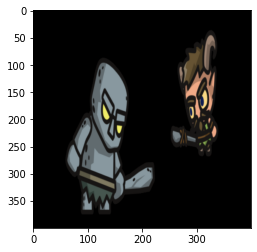

In [ ]:
plt.imshow(test_images[0][1].permute(1, 2, 0))

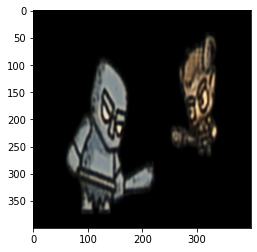

In [ ]:
recon_img = vae.reconstruct_img(test_images[0][0:10].cuda(), test_labels[0][0:10].cuda())
plt.imshow(recon_img[1].detach().cpu().permute(1,2,0)) # This was for 3 iterations.

### Sampling randomly from the inference model and generating an image

In [ ]:
r_img , r_attrs = vae.inference_model(cpts)

tensor([[0.4000, 0.3000, 0.3000]])
tensor([[0.2000, 0.2000, 0.4000, 0.2000]])


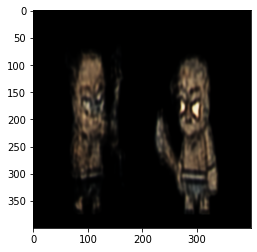

In [ ]:
plot_model_image(r_img)

In [ ]:
r_attrs

{'action': tensor([[0., 1., 0.]]),
 'actor': tensor([0., 1.]),
 'actor_attack': tensor([1]),
 'actor_defense': tensor([1]),
 'actor_strength': tensor([0]),
 'actor_type': tensor([[0., 1., 0.]]),
 'reaction': tensor([[0., 1., 0., 0.]]),
 'reactor': tensor([1., 0.]),
 'reactor_attack': tensor([1]),
 'reactor_defense': tensor([0]),
 'reactor_strength': tensor([1]),
 'reactor_type': tensor([[0., 0., 1.]]),
 'ys': tensor([[0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.]])}

### Generated Images conditioned on certain nodes of the DAG



tensor([[0.6000, 0.3000, 0.1000]])
tensor([[0.5000, 0.4000, 0.0500, 0.0500]])


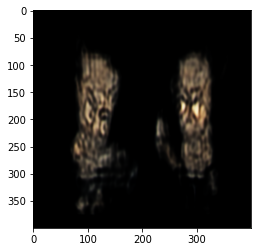

In [ ]:


# sample conditioning statements
cond1 = {
    "actor_attack": torch.tensor([1]).cuda(),
    "actor_defense": torch.tensor([1]).cuda(),
    "actor_strength": torch.tensor([1]).cuda(),
    "reactor_strength": torch.tensor([0]).cuda(),
    "reactor_attack": torch.tensor([0]).cuda(),
    "reactor_defense": torch.tensor([0]).cuda()
}

conditioned_model = pyro.condition(vae.inference_model, data=cond1)
c_img, c_attrs = conditioned_model(cpts)
plot_model_image(c_img)

In [ ]:
c_attrs

{'action': tensor([[1., 0., 0.]]),
 'actor': tensor([0., 1.]),
 'actor_attack': tensor([1]),
 'actor_defense': tensor([1]),
 'actor_strength': tensor([1]),
 'actor_type': tensor([[1., 0., 0.]]),
 'reaction': tensor([[0., 1., 0., 0.]]),
 'reactor': tensor([1., 0.]),
 'reactor_attack': tensor([0]),
 'reactor_defense': tensor([0]),
 'reactor_strength': tensor([0]),
 'reactor_type': tensor([[0., 0., 1.]]),
 'ys': tensor([[0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.]])}

tensor([[0.4000, 0.3000, 0.3000]])
tensor([[0.3000, 0.3000, 0.3990, 0.0010]])


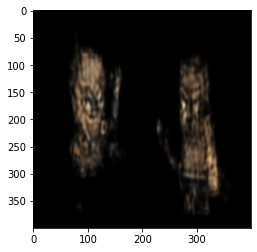

In [ ]:

# sample conditioning statements - sample on observed and infer latent.
cond2 = {
    "actor": torch.tensor([1,0]).cuda(),
    "reactor": torch.tensor([0,1]).cuda(),
    "actor_type": torch.tensor([1,0,0]).unsqueeze(0).cuda(),
    "reactor_type": torch.tensor([0,0,1]).unsqueeze(0).cuda()
}

conditioned_model = pyro.condition(vae.inference_model, data=cond2)
c_img, c_attrs = conditioned_model(cpts)
plot_model_image(c_img)

In [ ]:
c_attrs

{'action': tensor([[0., 1., 0.]]),
 'actor': tensor([1, 0]),
 'actor_attack': tensor([1]),
 'actor_defense': tensor([0]),
 'actor_strength': tensor([1]),
 'actor_type': tensor([[1, 0, 0]]),
 'reaction': tensor([[1., 0., 0., 0.]]),
 'reactor': tensor([0, 1]),
 'reactor_attack': tensor([0]),
 'reactor_defense': tensor([0]),
 'reactor_strength': tensor([1]),
 'reactor_type': tensor([[0, 0, 1]]),
 'ys': tensor([[1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]])}

In [ ]:
intervention1_cpts = {
    "action": torch.tensor([[1.0, 0.0, 0.0]]),
    
    "reaction": torch.tensor([[0.1757, 0.2846, 0.4659, 0.073]]),
    "character": torch.tensor([[0.5, 0.5]]),
    "type": torch.tensor([[0.33, 0.34, 0.33]]),
    "strength": torch.tensor([[0.4985, 0.5015]]),
    "defense": torch.tensor([[0.548, 0.452]]),
    "attack": torch.tensor([[0.60725, 0.39275]])
}

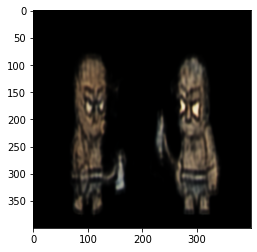

In [ ]:
i_img, i_attrs = vae.intervention_inference(intervention1_cpts)
plot_model_image(i_img)

In [ ]:
i_attrs

{'action': tensor([[1., 0., 0.]]),
 'actor': tensor([[1., 0.]]),
 'actor_attack': tensor([0]),
 'actor_defense': tensor([1]),
 'actor_strength': tensor([1]),
 'actor_type': tensor([[0., 0., 1.]]),
 'reaction': tensor([[0., 1., 0., 0.]]),
 'reactor': tensor([[1., 0.]]),
 'reactor_attack': tensor([1]),
 'reactor_defense': tensor([0]),
 'reactor_strength': tensor([0]),
 'reactor_type': tensor([[0., 0., 1.]]),
 'ys': tensor([[1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.]])}

### Generated Images after intervention on certain nodes of the DAG

tensor([[0.3000, 0.5000, 0.2000]])
tensor([[0.1000, 0.3000, 0.5500, 0.0500]])


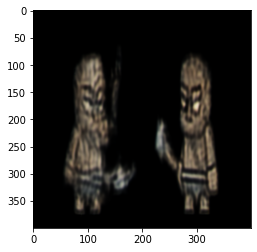

In [ ]:
intervene_cond  = {
    "actor_attack": torch.tensor(1).cuda(),
    "reactor_attack": torch.tensor(0).cuda(),
    "reactor_strength": torch.tensor(0).cuda()
}
intervened_model = pyro.do(vae.inference_model, data=intervene_cond)
intervened_img, model_attrs = intervened_model(intervention1_cpts)
plot_model_image(intervened_img)

In [ ]:
model_attrs

{'action': tensor([[0., 0., 1.]]),
 'actor': tensor([0., 1.]),
 'actor_attack': tensor(1),
 'actor_defense': tensor([0]),
 'actor_strength': tensor([0]),
 'actor_type': tensor([[1., 0., 0.]]),
 'reaction': tensor([[0., 0., 1., 0.]]),
 'reactor': tensor([0., 1.]),
 'reactor_attack': tensor(0),
 'reactor_defense': tensor([1]),
 'reactor_strength': tensor(0),
 'reactor_type': tensor([[0., 0., 1.]]),
 'ys': tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]])}